# Data Gaps and Quality Flags
---

## Learning Goals

By the end of this tutorial, you will:

- Have a working knowledge of _Kepler_ quality flags and be able to access them in light curve and TPF data.
- Be able to identify the cause of various types of gaps in the data.
- Understand the most common reasons for individual cadence exclusions.

## Introduction

This notebook is the first part of a series on identifying instrumental and systematic sources of noise in _Kepler_ and _K2_ data. In this tutorial, we will look at practical examples of data gaps and single-cadence quality issues in _Kepler_ data, and learn to identify their causes. Assumed knowledge for this tutorial is a good familiarity with light curve and target pixel file (TPF) data products, and the ability to work with their metadata.

## Imports

We'll use **[Lightkurve](https://docs.lightkurve.org/)** for downloading and handling _Kepler_ data throughout this tutorial. We'll also use **[NumPy](https://numpy.org/)** to perform a few auxiliary functions, and **[Matplotlib](https://matplotlib.org/)** for plotting.

In [1]:
import lightkurve as lk
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/lightkurve/prf/__init__.py:7: UserWarning: Warning: the tpfmodel submodule is not available without oktopus installed, which requires a current version of autograd. See #1452 for details.
  warnings.warn(


---

## 1. Background

The _Kepler_ space telescope observed the same patch of sky for four continuous years, between 2009 and 2013. Over the course of 18 observing quarters, it collected light curves and pixel data for 150,000 stars in 30-minute Long Cadence mode, and 512 stars per quarter in one-minute Short Cadence mode. Following the failure of two of the telescope's four reaction wheels, the telescope continued as the _K2_ mission, which observed along the ecliptic plane for 20 campaigns.

In this tutorial, we'll explore some quality issues that arose during both the _Kepler_ and _K2_ missions, and learn how to identify and mitigate them. It's important to note that many of these issues only appear in the calibrated pixels or simple aperture photometry (SAP) data, and more still are removed by a quality masking process which we'll discuss in the next section. If you're working with presearch data conditioning SAP (PDCSAP) light curves, you won't run into many of these issues.

### 1.1 Quality flags

Before we look at some practical examples in time series data, let's familiarize ourselves with how data gaps and single-cadence quality events are identified in _Kepler_ data files. Every _Kepler_ FITS file has a `QUALITY` column, which contains a quality flag for each individual data cadence. These flags comprise of one or more binary bits, which are expressed as an integer. A handy reference document for _Kepler_'s quality flags is Table 2-3 in the [MAST Kepler Archive Manual](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/k2/_documents/MAST_Kepler_Archive_Manual_2020.pdf).

Let's start by downloading the data we'll work with throughout this tutorial:

In [2]:
lc = lk.search_lightcurve('KIC 2436365', mission='kepler', author='kepler', quarter=2).download()

By default, Lightkurve downloads quality-masked data. This means that a variety of cadences with a non-zero quality flag will already be removed from the light curves or TPFs you download using the instruction above.

For this tutorial, we are also going to download some TPF data with no quality mask applied.  We can do this by passing the optional `quality_bitmask=0` argument to the `download()` method as follows:

In [3]:
tpf = lk.search_targetpixelfile('KIC 2436365', quarter=2).download(quality_bitmask=0)

Passing `quality_bitmask=0` has the effect of including every cadence in the data, even those with serious quality issues or NaN ([not a number](https://en.wikipedia.org/wiki/NaN)) values in the flux. This is not necessarily recommended when using Lightkurve, but here it will allow us to explore a wide variety of data quality issues, many of which will be useful to know about if you're working directly with FITS files from MAST.

Now that we have our data, let's have a look at the range of quality flags present. Remember, this is the unmasked data, so every flagged cadence is included.

Here, we're using the NumPy function [`unique()`](https://numpy.org/doc/stable/reference/generated/numpy.unique.html), which takes an array as its input and returns every unique value:

In [4]:
np.unique(tpf.quality)

array([     0,      1,     16,     64,    128,    144,    256,   4160,
         8192,   8208,   8320,  12352,  16384,  32772,  32778,  32800,
        32804,  32816,  98305,  98312,  98314, 393216, 393232, 393344,
       401408, 409600], dtype='>i4')

You'll notice that some of these appear to be integers that correspond to bits — that is, powers of two — but others are additive. This indicates that multiple quality issues are present in a particular cadence.

We can use Lightkurve's [`decode()`](https://docs.lightkurve.org/api/lightkurve.utils.KeplerQualityFlags.html#lightkurve.utils.KeplerQualityFlags.decode) function for accessing the information stored in each quality flag:

In [5]:
for flag in np.unique(tpf.quality):
    print(flag, lk.KeplerQualityFlags.decode(flag))

0 []
1 ['Attitude tweak']
16 ['Zero crossing']
64 ['Argabrightening']
128 ['Cosmic ray in optimal aperture']
144 ['Zero crossing', 'Cosmic ray in optimal aperture']
256 ['Manual exclude']
4160 ['Argabrightening', 'Argabrightening on CCD']
8192 ['Cosmic ray in collateral data']
8208 ['Zero crossing', 'Cosmic ray in collateral data']
8320 ['Cosmic ray in optimal aperture', 'Cosmic ray in collateral data']
12352 ['Argabrightening', 'Argabrightening on CCD', 'Cosmic ray in collateral data']
16384 ['Detector anomaly']
32772 ['Coarse point', 'No fine point']
32778 ['Safe mode', 'Earth point', 'No fine point']
32800 ['Desaturation event', 'No fine point']
32804 ['Coarse point', 'Desaturation event', 'No fine point']
32816 ['Zero crossing', 'Desaturation event', 'No fine point']
98305 ['Attitude tweak', 'No fine point', 'No data']
98312 ['Earth point', 'No fine point', 'No data']
98314 ['Safe mode', 'Earth point', 'No fine point', 'No data']
393216 ['Rolling band in optimal aperture', 'Rolling

We can use Python's "bitwise and" operator (&) to select the cadence numbers affected by a specific quality flag as follows:

In [6]:
tpf.cadenceno[(tpf.quality & 64) > 0]  # cadence numbers flagged for "Argabrightening" (flag 64)

array([4060, 5767, 6432, 6796, 6797], dtype='>i4')

In the following sections, we'll walk through the majority of these data quality events, and look at practical examples in the light curve and TPF we downloaded above.

Some of these flags are not covered in this tutorial, such as rolling bands. For more information on other data quality issues, see other tutorials in this series, as well as the various [_Kepler_ Data Handbooks](https://archive.stsci.edu/missions-and-data/kepler/documents).

## 2. Common Data Gaps

The nominal _Kepler_ mission observed one area continuously between 2009 and 2013 — but of course, there were various necessary breaks in that continuity. For example, the telescope rotated at the end of each quarter, which necessitated a break in data collection.

We can use quality flags to identify these various events, but often it's more convenient to check the _Kepler_ Mission Timeline, from the [_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf):

![Kepler Mission Timeline from the Data Characteristics Handbook, a calendar showing Quarters 0–17 from 2009–13, with major events and data gaps marked.](kepler-mission-timeline.png)

Throughout this section we'll explore the most common reasons for gaps in _Kepler_ data: monthly data downlinks, safe modes, and coarse pointing/loss of fine pointing. Though we're looking at _Kepler_ data here, these data gaps can also be found in _K2_ mission data.

### 2.1 Monthly data downlink

During the _Kepler_ mission, the telescope changed its orientation once a month to point at Earth and downlink the last month of data. This caused a gap in the time series data, as the telescope could not collect while it was downlinking. When the telescope returned to regular pointing, its motion induced what is known as a "thermal transient." This means that the telescope components and detector electronics underwent a temperature change, and the electron count reading was temporarily increased. A change in temperature can slightly change the telescope focus. This manifests in the simple aperture photometry (SAP) data as a downward slope caused by "reheating," while the flux returns to its previous level. The thermal transient is corrected in PDCSAP data; there is no quality flag for data affected by a thermal transient. ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.5.)

The following code uses Matplotlib to zoom in on an Earth pointing event and highlight the affected section of the SAP light curve:

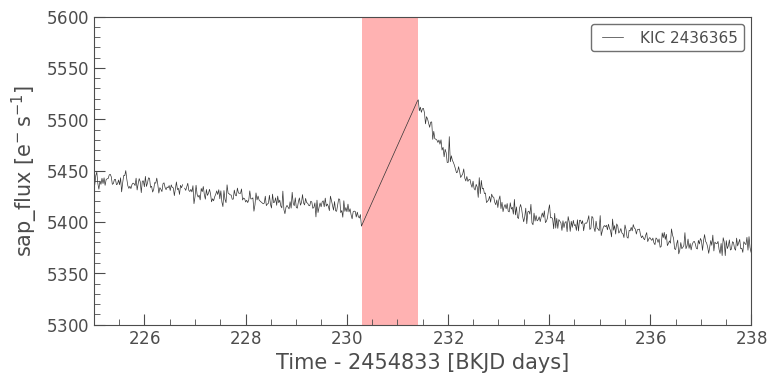

In [7]:
ax = lc.plot(column='sap_flux')
ax.set_xlim(225, 238)
ax.set_ylim(5300, 5600)
ax.fill_betweenx(ax.get_ylim(), 230.3, 231.4, facecolor='r', alpha=0.3);

### 2.2 Safe modes

Safe modes ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 4.2) are another type of thermal transient that appears in _Kepler_ data. A safe mode occured when the telescope temporarily shut off operation due to an unexpected event, usually caused by an issue with the detector electronics.

There were eleven safe mode events throughout the _Kepler_ mission, and three during _K2_, in Campaigns 0, 9, and 12. The following code zooms in on the Quarter 2 safe mode, in the same data we've used above; note the similarity in appearance between the two thermal transient events.

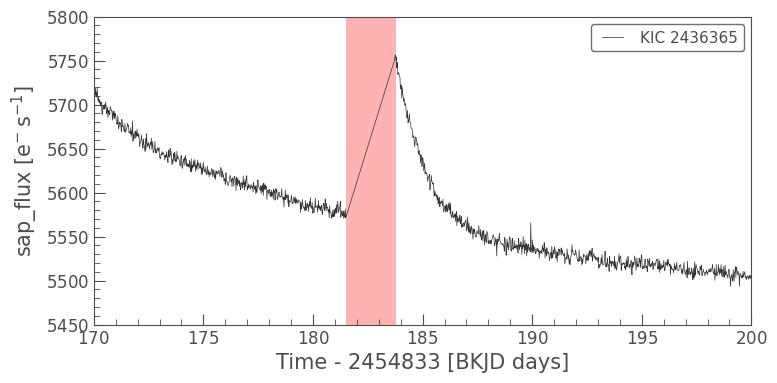

In [8]:
ax = lc.plot(column='sap_flux')
ax.set_xlim(170, 200)
ax.set_ylim(5450, 5800)
ax.fill_betweenx(ax.get_ylim(), 181.5, 183.8, facecolor='r', alpha=0.3);

### 2.3 Coarse pointing and loss of fine pointing

Running the code below, you'll see two highlighted regions where there is no thermal transient, but still a gap in the data. Often, gaps like this are caused by a loss of fine pointing ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 4.3). Because there is lower photometric precision when this occurs, these cadences are not suggested for use in photometry, and are replaced with NaNs.

In the `QUALITY` column, there are two flags for this situation: a 4 (bit 3) for coarse point, and 32768 (bit 16) for a loss of fine point. Coarse point is a manual flag, based on preprocessing, and coarse point cadences are removed based on an expected loss of fine pointing. Cadences marked as "no fine point" are due to unexpected events; in practice, these two quality issues manifest in the same manner as gapped data.

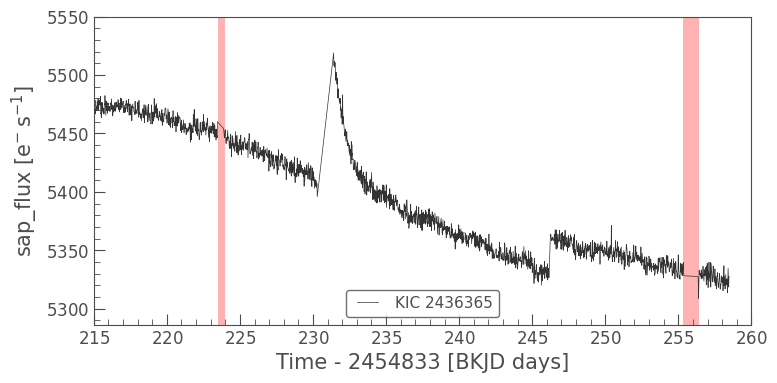

In [9]:
ax = lc.plot(column='sap_flux')
ax.set_xlim(215,260)
ax.set_ylim(ymax=5550)
ax.fill_betweenx(ax.get_ylim(), 223.5, 224, facecolor='r', alpha=0.3)
ax.fill_betweenx(ax.get_ylim(), 255.3, 256.4, facecolor='r', alpha=0.3);

Let's also look at a TPF cadence affected by a loss of fine pointing:

[[[nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]
  [nan nan nan nan nan]]] electron / s


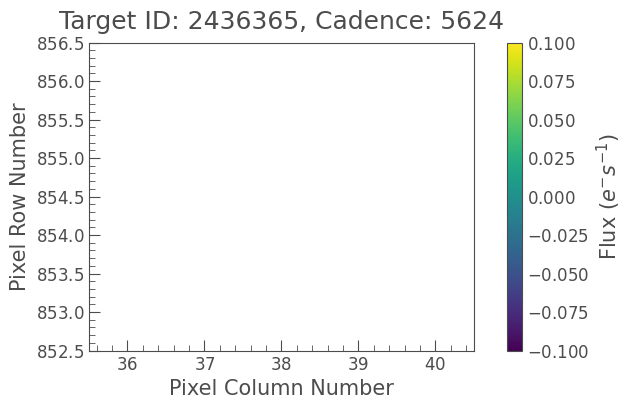

In [10]:
print(tpf.flux[np.argwhere((tpf.quality & 32804) > 0)][0])
tpf.plot(cadenceno=tpf.cadenceno[np.argwhere(tpf.quality == 32804)[0]]);

As you can see, there's no data available for this cadence at the TPF level. The vast majority of data affected by a loss of fine pointing/coarse pointing during the _Kepler_ and _K2_ missions is "gapped" like this. When performing photometry or light curve corrections, it's important to pay attention to the data on either side of these gaps and make sure you don't overcorrect it.

## 3. Single-Cadence Events

We've now seen some situations in _Kepler_ data where you'll observe a gap in the data — or NaN flux — and what the time series looks like on either side of those events. But there are many quality issues which can have an impact on one or more cadences at a time, which aren't necessarily as evident as data gaps. In the following sections, we'll look at some of the causes behind these single-cadence quality issues, where you'll find them, and how to mitigate them in a practical context.

### 3.1 Cosmic rays

Cosmic rays on the detector ([_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf), Section 4.16) are an unavoidable source of quality issues in all space based data. Depending on the severity of the event, an incidence of a cosmic ray can lead to sudden pixel sensitivity dropouts (SPSD) — covered in another tutorial in this series — or even long-term damage. Here, we'll only look at the short-term events.

The cell below plots a section of our light curve for KIC 2436365 from above, showing a spike caused by a cosmic ray hitting the detector. Note that this is PDCSAP flux: most cosmic rays are removed by  presearch data conditioning (PDC), but those that aren't can be caught by outlier clipping or, in this case, may not be a large enough spike to cause problems.

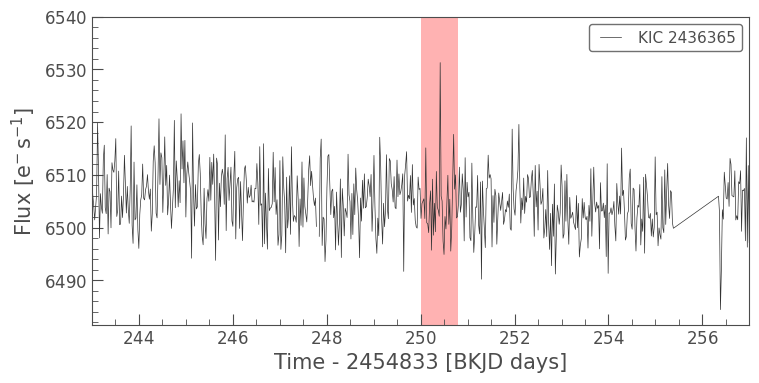

In [11]:
ax = lc.plot()
ax.set_xlim(243, 257)
ax.set_ylim(ymax=6540)
ax.fill_betweenx(ax.get_ylim(), 250, 250.8, facecolor='r', alpha=0.3)

### 3.2 Argabrightening

Argabrightening ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.8) is a single-cadence quality issue that looks similar to a cosmic ray on the detector. In fact, Argabrightening is thought to be caused by debris hitting the instrument, causing a brief increase in flux. This is distinct from the electronic event caused by a cosmic ray corrupting the pixel readout: Argabrightening is the result of physical illumination.

Using Lightkurve's [`KeplerQualityFlags.decode()`](https://docs.lightkurve.org/api/lightkurve.utils.KeplerQualityFlags.html?highlight=decode#lightkurve.utils.KeplerQualityFlags.decode) function in [Section 1.1](#1.1-Quality-flags), we saw that a quality flag of 4160 indicates an Argabrightening event on the charge-coupled device (CCD) and in the optimal aperture used for photometry. Let's see where that shows up in our data:

In [12]:
tpf.time.value[(tpf.quality & 4160) > 0]

array([191.8960099 , 226.77612309, 240.36418455, 247.80180137,
       247.82223423])

Argabrightening events are removed by the _Kepler_ pipeline for both SAP and PDCSAP data. To see this Argabrightening event, let's create our own light curve from the TPF, using custom aperture photometry. We can confirm that the spike in the data is right where we expect it:

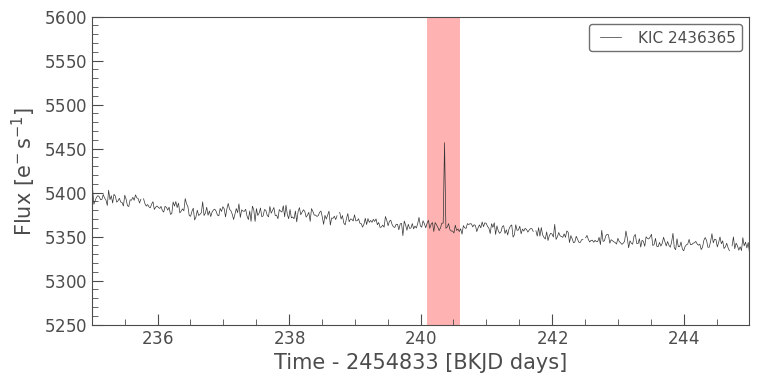

In [13]:
ax = tpf.to_lightcurve().plot()
ax.set_xlim(235,245)
ax.set_ylim(5250,5600)
ax.fill_betweenx(ax.get_ylim(), 240.1, 240.6, facecolor='r', alpha=0.3);

### 3.3 Attitude tweaks

_Kepler_'s orientation, or attitude, was adjusted every few days during Quarters 0, 1, and 2 of the nominal mission. Specifically, attitude tweaks ensured that no star would ever move more than 1/100th of a pixel from its expected location in each cadence ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 4.4). From Quarter 3 onwards, changes to the telescope's Fine Guidance Sensor (FGS) system (see the [_Kepler_ Instrument Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19033-002-instrument-hb.pdf), particularly sections 2.1 and 2.5.1) led to reduced drift, which meant that attitude tweaks were no longer necessary.

Because the drift distances in _Kepler_'s first three quarters were so small, they're hard to detect without checking the quality flags. Additionally, the discontinuities were for the most part corrected by the data processing pipeline, with only a few remaining:

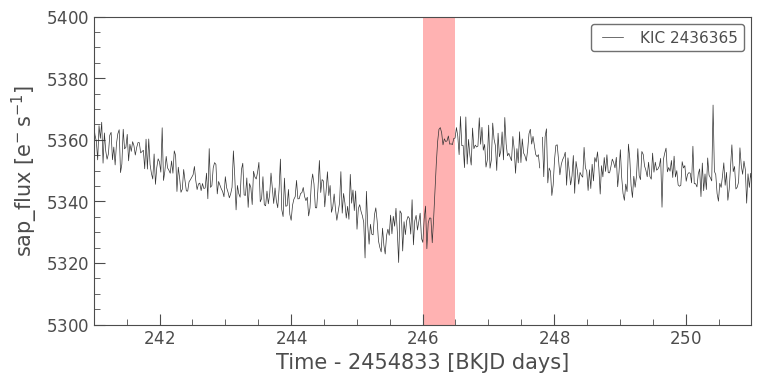

In [14]:
ax = lc.plot(column='sap_flux')
ax.set_xlim(241, 251)
ax.set_ylim(5300, 5400)
ax.fill_betweenx(ax.get_ylim(), 246, 246.5, facecolor='r', alpha=0.3);

### 3.4 Reaction wheel events

_Kepler_'s attitude was controlled initially by four reaction wheels. Bits 5 and 6 are allocated to two data quality events caused by the reaction wheels: zero crossings and momentum desaturation.

Zero crossings (bit 5/integer 16) occur when the reaction wheels have zero angular velocity ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.4). This caused the telescope's point to degrade for a few minutes at a time. Because of this short timescale, reaction wheel zero crossings are mostly an issue in Short Cadence data, where they manifest as negative spikes in the flux data. Zero crossing events became less prominent after the failure of one of _Kepler_'s reaction wheels in Quarter 14, due to an increase in speed of the remaining reaction wheels. There were no reaction wheel zero crossings in the _K2_ mission.

Momentum desaturation (bit 6/integer 32) was a consequence of a build up of torque on the reaction wheels ([_Kepler_ Data Characteristics Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/Data_Characteristics.pdf), Section 5.3). Desaturation events occurred every 146 Long Cadences during the _Kepler_ mission, leading to coarse pointing mode (as above) and NaN values in the light curves for one Long Cadence or several Short Cadences at a time.



### 3.5 Manual exclusions

For various reasons, some cadences were manually excluded during the data processing stage. In general, these cadences were those on either side of gaps and discontinuities, but sometimes manual exclusions were used to cover specific events that didn't fall under any other category. For example, during Quarter 12, a series of three coronal mass ejections from the Sun led to multiple cadences being manually excluded ([_Kepler_ Data Release 25 Notes](https://archive.stsci.edu/kepler/release_notes/release_notes25/KSCI-19065-002DRN25.pdf), Section 12.2). Further solar flares and coronal mass ejections led to manual exclusions in Campaign 15 of _K2_ ([_K2_ Data Release 22 Notes](https://archive.stsci.edu/missions/k2/doc/drn/KSCI-19138-001_K2-DRN22_C15.pdf), Section 2.2). On both occasions, these incidences led to increased noise and reduced accuracy in pointing.

The code below plots the SAP light curve for Quarter 12 of KIC 8805616 with no quality-flagged data excluded. Here, you can clearly see the data quality issues caused by the coronal mass ejections, which are highlighted:

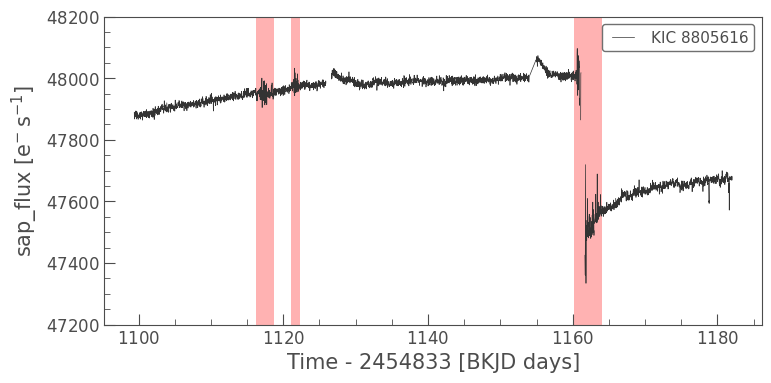

In [15]:
lc_12 = lk.search_lightcurve('KIC 8805616', quarter=12).download(quality_bitmask=0)
ax = lc_12.plot(column='sap_flux')
ax.set_ylim(47200,48200)
ax.fill_betweenx(ax.get_ylim(), 1116.2, 1118.7, facecolor='r', alpha=0.3)
ax.fill_betweenx(ax.get_ylim(), 1121.1, 1122.3, facecolor='r', alpha=0.3)
ax.fill_betweenx(ax.get_ylim(), 1160.2, 1164.0, facecolor='r', alpha=0.3)

## 4. _K2_

The _K2_ mission relied on only two of _Kepler_'s reaction wheels, meaning it required an additional thruster firing every six hours to maintain pointing. This led to a six-hour drift in _K2_ data; while the drift is corrected in Long Cadence data by PDC, data taken during the thruster firings is treated the same way as gaps or single-cadence quality issues in _Kepler_ data. There are two quality bits allocated to thruster firings: bit 21 for a thruster firing, and bit 20 for a possible thruster firing.

To get an idea of what the six-hour drift looks like, let's start by downloading some _K2_ data.

In [16]:
lc_k2 = lk.search_lightcurve('EPIC 211414081', cadence='long', campaign=5).download(quality_bitmask=0)

/home/runner/micromamba/envs/ci-env/lib/python3.11/site-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(


Even with `quality_bitmask=0`, the data is gapped at all cadences flagged with bit 20 or 21. You can test this yourself by running the following code, and noting that there are no `time` values provided for any cadences with these quality flags:

In [17]:
for val in lc_k2.quality.value:
  print(lc_k2.time[np.argwhere((val & 20) > 0 or (val & 21) > 0)])

[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

Now let's look at the SAP light curve for this star, and see what the six-hour drift looks like in practice:

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='sap_flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

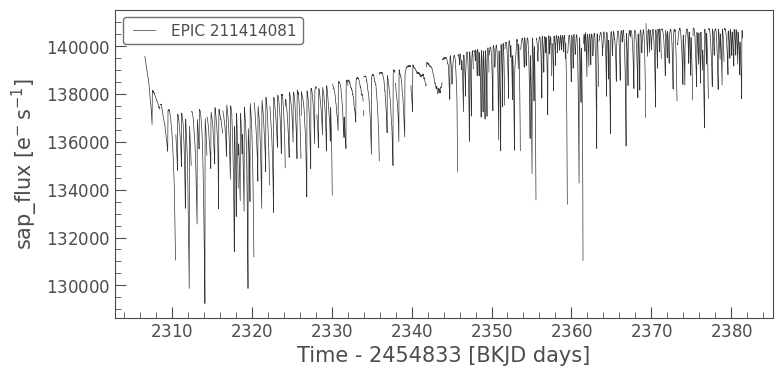

In [18]:
lc_k2.plot(column='sap_flux')

Fortunately, this systematic is well-represented by the cotrending basis vectors (CBVs) used in the PDC pipeline:

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

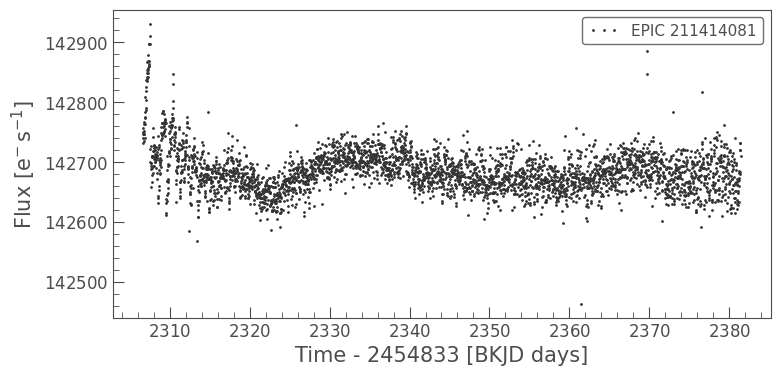

In [19]:
lc_k2.plot(marker='.', linewidth=0)

The [_K2_ Handbook](https://archive.stsci.edu/files/live/sites/mast/files/home/missions-and-data/kepler/_documents/KSCI-19116-002.pdf) cautions that these effects can never be fully corrected — you can see this particularly to the left of the plot above. But overall, PDC successfully removes the six-hour drift from _K2_ Long Cadence data, providing high-quality time series data for all targets.

In the next tutorial in this series, we'll revisit EPIC 211414081, and look at how the thruster firings lead to persistent systematics in Short Cadence data.

## About this Notebook

**Author:** [Isabel Colman](http://orcid.org/0000-0001-8196-516X) (`isabel.colman@sydney.edu.au`)

**Updated on:** 2020-09-29


# Citing Lightkurve and Astropy

If you use `lightkurve` or `astropy` for published research, please cite the authors. Click the buttons below to copy BibTeX entries to your clipboard.

In [20]:
lk.show_citation_instructions()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>